In [596]:
import pandas as pd 
import numpy as np 
import re
from openai import OpenAI
import ast
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr, pearsonr
import pickle
import itertools
client = OpenAI(api_key=open("/Users/mosobay/Dropbox (MIT)/research/openai_api", "r").read().strip())

# Ideas: 
* What do we learn from rank variability? 

In [1]:
skill_str = """Active Learning
Active Listening
Complex Problem Solving
Coordination
Critical Thinking
Instructing Judgment and Decision Making
Learning Strategies
Management of Financial Resources
Management of Material Resources
Management of Personnel Resources
Mathematics
Monitoring
Negotiation
Operations Analysis
Persuasion
Programming
Reading Comprehension
Science
Service Orientation
Social Perceptiveness
Speaking
Systems Analysis
Systems Evaluation
Time Management
Writing
Category Flexibility
Deductive Reasoning
Fluency of Ideas
Inductive Reasoning
Information Ordering
Mathematical Reasoning
Memorization
Near Vision
Number Facility
Oral Comprehension
Oral Expression
Originality
Problem Sensitivity
Speech Clarity
Speech Recognition
Speed of Closure
Written Comprehension
Written Expression
Administration and Management
Biology
Clerical
Communications and Media
Computers and Electronics
Customer and Personal Service
Economics and Accounting
Education and Training
English Language
Fine Arts
Foreign Language
Geography
History and Archeology
Law and Government
Mathematics Knowledge
Medicine and Dentistry
Personnel and Human Resources
Philosophy and Theology
Psychology
Sales and Marketing
Sociology and Anthropology
Telecommunications
Therapy and Counseling
Analyzing Data or Information
Assisting and Caring for Others
Coaching and Developing Others
Communicating with Persons Outside Organization
Communicating with Supervisors, Peers, or Subordinates
Coordinating the Work and Activities of Others
Developing Objectives and Strategies
Developing and Building Teams
Documenting/Recording Information
Establishing and Maintaining Interpersonal Relationships
Evaluating Information to Determine Compliance with Standards
Getting Information
Guiding, Directing, and Motivating Subordinates
Identifying Objects, Actions, and Events
Interacting With Computers
Interpreting the Meaning of Information for Others
Judging the Qualities of Things, Services, or People
Making Decisions and Solving Problems
Monitoring and Controlling Resources
Organizing, Planning, and Prioritizing Work
Performing Administrative Activities
Performing for or Working Directly with the Public
Processing Information
Provide Consultation and Advice to Others
Resolving Conflicts and Negotiating with Others
Scheduling Work and Activities
Selling or Influencing Others
Staffing Organizational Units
Thinking Creatively
Training and Teaching Others
Updating and Using Relevant Knowledge"""

In [3]:
def clean_task_html(text):
    pattern = r"(?<=Set-Up)(.*)"
    match = re.search(pattern, text)
    extracted_text = match.group(1)
    no_html = re.sub(r"<[^>]+>", "", extracted_text)
    return no_html 

In [4]:
def get_gpt_sorted_skills(task_desc):
    system_prompt = """You are assisting a manager in understanding the relative importance of different abilities to different tasks. The tasks are all completed on a screen.
    You will be presented with a task description, and then a list of 97 skills. Return the COMPLETE list of skills, sorted in descending order of their importance to successfully completing the task.
    ONLY RETURN THE LIST OF SKILL IDS IN ORDER OF IMPORTANCE TO THE TASK, WITHOUT ANY OTHER TEXT. 
    RETURN THE LIST IN THE FORMAT [LIST ITEM 1, LIST ITEM 2, ...]"""
    
    task_prompt = f"The task description: {task_desc}"
    
    skill_prompt = "The list of skills is:\n" + "\n".join(list_cog_skills)
    
    response = client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": task_prompt},
            {"role": "user", "content": skill_prompt}])
    
    return response
    

In [5]:
# df_tasks = pd.read_csv("102_tasks_with_sources_clean.csv")
df_tasks = pd.read_csv("/Users/mosobay/Dropbox (MIT)/research/homo_silicus/task_htmls.csv")
df_tasks["task_desc"] = [clean_task_html(x) for x in df_tasks["html"]]
df_abilities = pd.read_excel("/Users/mosobay/Downloads/Abilities.xlsx")
# df_task_sample = df_tasks.sample(10, random_state=2024)

In [6]:
list_cog_skills = skill_str.split("\n")
list_cog_skills = [f"SKILL ID {x}: {list_cog_skills[x]}" for x in range(len(list_cog_skills))]

In [7]:
gpt_responses = []

for task_desc in tqdm(df_tasks["task_desc"].values): 
    gpt_responses.append(get_gpt_sorted_skills(task_desc))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [34:55<00:00, 20.55s/it]


In [12]:
df_tasks["gpt_response"] = gpt_responses
df_tasks["gpt_parsed"] = [ast.literal_eval(response.choices[0].message.content.strip(".")) for response in df_tasks["gpt_response"]]

In [24]:
# It used 97 as a task id, even though the max index is 96... manually override for now 
df_tasks.loc[:,list_cog_skills] = pd.DataFrame([dict(zip(np.array(list_cog_skills)[np.clip(x, a_max=96, a_min=0)], range(len(x)))) for x in df_tasks["gpt_parsed"]]).to_numpy()

In [26]:
df_tasks.to_pickle("gpt_skill_ratings.pkl")

In [42]:
df_skill_summaries = df_tasks[list_cog_skills].describe().T.sort_values("mean").assign(cov = lambda x: x["std"] / x["mean"]).sort_values("cov")[-50:]

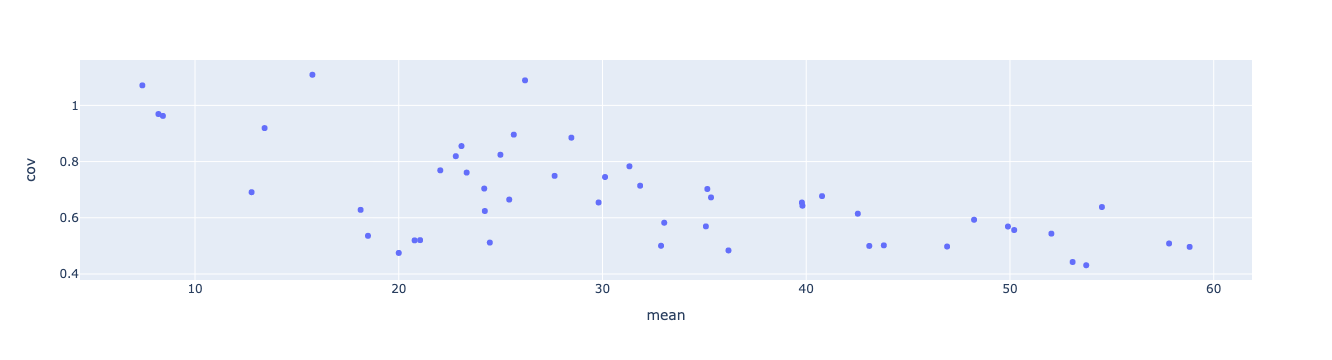

In [52]:
px.scatter(x="mean", y="cov", data_frame=df_skill_summaries.reset_index(), hover_name="index")

In [100]:
df_tasks

,task,html,github,path,script,task_desc,gpt_response,gpt_parsed,SKILL ID 0: Active Learning,SKILL ID 1: Active Listening,...,SKILL ID 87: Performing for or Working Directly with the Public,SKILL ID 88: Processing Information,SKILL ID 89: Provide Consultation and Advice to Others,SKILL ID 90: Resolving Conflicts and Negotiating with Others,SKILL ID 91: Scheduling Work and Activities,SKILL ID 92: Selling or Influencing Others,SKILL ID 93: Staffing Organizational Units,SKILL ID 94: Thinking Creatively,SKILL ID 95: Training and Teaching Others,SKILL ID 96: Updating and Using Relevant Knowledge
0,Euclidean traveling salesperson,<h2>Euclidean traveling salesperson</h2><br><h...,https://api.github.com/repos/Watts-Lab/task-ma...,tasks/summaries/Euclidean traveling salesperso...,https://api.github.com/repos/Watts-Lab/task-ma...,"Participants get a map with multiple cities, w...",ChatCompletion(id='chatcmpl-8f3U1Qogzs9dwIROoP...,"[2, 10, 13, 21, 22, 26, 28, 29, 30, 33, 37, 66...",0.0,1.0,...,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,NaN
1,Moral Reasoning (Disciplinary Action Case),<h2>Moral Reasoning (Disciplinary Action Case)...,https://api.github.com/repos/Watts-Lab/task-ma...,tasks/summaries/Moral Reasoning (Disciplinary ...,https://api.github.com/repos/Watts-Lab/task-ma...,"Participants read a fictitious, controversial ...",ChatCompletion(id='chatcmpl-8f3UK1RfTMcaYRFjSx...,"[5, 12, 4, 83, 19, 90, 2, 61, 63, 56, 16, 1, 2...",6.0,68.0,...,1.0,43.0,87.0,NaN,12.0,14.0,63.0,89.0,39.0,52.0
2,To evacuate or not to evacuate,<h2>To evacuate or not to evacuate</h2><br><h2...,https://api.github.com/repos/Watts-Lab/task-ma...,tasks/summaries/To evacuate or not to evacuate...,https://api.github.com/repos/Watts-Lab/task-ma...,Participants read about a situation in which '...,ChatCompletion(id='chatcmpl-8f3UcKvXA7mjhMPoge...,"[5, 83, 37, 26, 28, 4, 7, 33, 57, 30, 77, 66, ...",41.0,34.0,...,48.0,45.0,80.0,NaN,28.0,26.0,59.0,93.0,43.0,NaN
3,Allocating resources to programs,<h2>Allocating resources to programs</h2><br><...,https://api.github.com/repos/Watts-Lab/task-ma...,tasks/summaries/Allocating resources to progra...,https://api.github.com/repos/Watts-Lab/task-ma...,Partipants are given a list of complex competi...,ChatCompletion(id='chatcmpl-8f3UsuHftwJPydv5y4...,"[83, 7, 12, 90, 5, 19, 1, 20, 94, 4, 72, 75, 6...",20.0,54.0,...,2.0,13.0,86.0,60.0,7.0,48.0,28.0,88.0,63.0,85.0
4,Shopping plan,<h2>Shopping plan</h2><br><h2>1. Set-Up</h2><p...,https://api.github.com/repos/Watts-Lab/task-ma...,tasks/summaries/Shopping plan-writeup.md,https://api.github.com/repos/Watts-Lab/task-ma...,Each participant has a grocery list and a map ...,ChatCompletion(id='chatcmpl-8f3VB1j9kMnTgZYTgk...,"[5, 23, 2, 26, 28, 29, 83, 85, 10, 30, 33, 57,...",2.0,8.0,...,55.0,56.0,69.0,59.0,38.0,53.0,35.0,72.0,90.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Investment game (hidden-profile),<h2>Investment game (hidden-profile)</h2><br><...,https://api.github.com/repos/Watts-Lab/task-ma...,tasks/summaries/Investment game (hidden-profil...,https://api.github.com/repos/Watts-Lab/task-ma...,Participants are asked to take the role of the...,ChatCompletion(id='chatcmpl-8f3zrUNSvh1YpkZfKi...,"[5, 16, 12, 4, 83, 1, 19, 49, 66, 7, 77, 21, 2...",22.0,31.0,...,2.0,15.0,59.0,86.0,16.0,28.0,40.0,83.0,53.0,89.0
98,Dictator game and its variants,<h2>Dictator game and its variants</h2><br><h2...,https://api.github.com/repos/Watts-Lab/task-ma...,tasks/summaries/Dictator game and its variants...,https://api.github.com/repos/Watts-Lab/task-ma...,Participants are placed into pairs and randoml...,ChatCompletion(id='chatcmpl-8f40IAPTOb4KyM2Jdq...,"[5, 83, 19, 7, 26, 28, 4, 66, 37, 30, 76, 23, ...",69.0,44.0,...,88.0,37.0,84.0,40.0,24.0,60.0,91.0,83.0,74.0,59.0
99,Intergroup Prisoner's Dilemma,<h2>Intergroup Prisoner's Dilemma</h2><br><h2>...,https://api.github.com/repos/Watts-Lab/task-ma...,tasks/summaries/Intergroup Prisoner's Dilemma-...,https

In [55]:
df_tasks["task_desc"][31]

'The participants see a shared virtual canvas with many different cursors moving around. Each participant controls their own cursor (which is denoted by a unique color and the word "YOU"). Participants are able to use the controls to move their cursor and "walk" around the virtual space.An underlying system sets a "point value" for each location in the space. That is, walking to specific locations in the virtual space will earn the participant more points. Participants will be able to see how many points their current location gives them, and they will also see the running total of how many points they earned so far. However, participants do not know where the high-point-earning locations are, so they must wander around the virtual room. Participants lose all their points if they touch the wall.2. Objective / GoalThe goal is to maximize points in the game by discovering and moving your cursor to the highest point-earning locations in the virtual space. Participants try to get as many p

In [97]:
summarize_skill = "SKILL ID 54: Geography"
df_tasks.sort_values(summarize_skill)[["task", summarize_skill]][:50]

,task,SKILL ID 54: Geography
70,Wildcam Gorongosa (Zooniverse),1.0
53,Random dot motion,34.0
14,Letters-to-numbers problems (cryptography),35.0
30,Estimating geological metrics,36.0
49,Desert survival,36.0
42,Trivia Multiple Choice Quiz,38.0
19,Putting food into categories,41.0
35,Reproducing arts,45.0
9,Estimating pages of a book,47.0
22,Recall association,48.0


In [93]:
def summarize_task(task_name):
    print(df_tasks.query("task == @task_name")["task_desc"].values[0])
    print("\n")
    print(df_tasks.query("task == @task_name").filter(like="SKILL").T.iloc[:,0].sort_values().to_string())

In [103]:
summarize_task("Advertisement writing")

Participants were given the description of a product from Kickstarter. For example, they could read about "Soapstone: the Sustainable Travel Soap Dispenser," and learn about its features.2. Objective / GoalThe goal was to write an online text advertisement of no more than 30 characters for the Kickstarter product. The advertisement had to be creative, informative, and get people to click. When working in teams, participants needed to submit a single collective writeup, produced within the time limit.


SKILL ID 26: Deductive Reasoning                                               0.0
SKILL ID 19: Social Perceptiveness                                             1.0
SKILL ID 53: Foreign Language                                                  2.0
SKILL ID 68: Coaching and Developing Others                                    3.0
SKILL ID 21: Systems Analysis                                                  4.0
SKILL ID 93: Staffing Organizational Units                                   

# Pairwise comparisons 
* "In terms of" just make this the actual dimensions 

In [560]:
df_tasks.loc[0]

task                                        Euclidean traveling salesperson
html                      <h2>Euclidean traveling salesperson</h2><br><h...
github                    https://api.github.com/repos/Watts-Lab/task-ma...
path                      tasks/summaries/Euclidean traveling salesperso...
script                    https://api.github.com/repos/Watts-Lab/task-ma...
task_desc                 Participants get a map with multiple cities, w...
Q1concept_behav                                                         0.0
Q3type_1_planning                                                  0.521739
Q4type_2_generate                                                  0.043478
Q6type_5_cc                                                        0.086957
Q7type_7_battle                                                    0.304348
Q8type_8_performance                                               0.130435
Q9divisible_unitary                                                0.047619
Q10maximizin

In [561]:
df_tasks["task_desc"][0]

'Participants get a map with multiple cities, which are displayed as dots on the screen. These dots can be connected by different "paths" by clicking on two dots one after the other. For example, clicking on point A, then point B, would draw a "path" between A and B. All participants, who are working on individual screens, are shown a shared map of the cities and can click and interact with it simultaneously.2. Objective / GoalThe goal is to find and select the precise shortest path through the cities within a fixed amount of time. This is the sequence of cities corresponding to the shortest possible path to traverse through all of the cities, forming a cycle (or loop). In other words, the participant should click through the dots in a sequence, thus drawing a path that touches every city exactly once, and the first city twice: you can think of it as a "traveling salesman" who visits each city on the map before returning to his home city. Imagine that the shortest path involves going f

In [228]:
def pairwise_task_comparison(ref_task_desc, task_a, task_b):
    system_prompt = """You will be presented with a description of a reference task, and descriptions of two other tasks (Task A, and Task B).
    Holding the team completing the tasks constant, determine which of the two tasks is most similar to the reference task in terms of team dynamics.
    Even if you think both Task A and Task B are irrelevant to the reference task, you must make a choice about which is MOST similar. 
    Present your choice (only say either A or B) and your rationale. YOUR ANSWER MUST FOLLOW THIS JSON FORMAT: {"choice":[YOUR CHOICE], "rationale":[YOUR RATIONALE]}
    """
    
    ref_task_prompt = f"The reference task description is: {ref_task_desc}"
    
    taskA_prompt = f"Task A is: {task_a}"
    taskB_prompt = f"Task B is: {task_b}"
    
    response = client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": ref_task_prompt},
            {"role": "user", "content": taskA_prompt},
            {"role": "user", "content": taskB_prompt}],
        temperature=0)
    
    return response

In [229]:
df_tasks = pd.read_csv("/Users/mosobay/Dropbox (MIT)/research/homo_silicus/task_htmls.csv")
df_tasks["task_desc"] = [clean_task_html(x) for x in df_tasks["html"]]
df_taskmap = pd.read_csv("task_map.csv")
df_tasks = df_tasks.merge(df_taskmap, on="task", how="left")

In [231]:
df_tasks.shape

(102, 30)

In [441]:
sample_task_ids = df_tasks.sample(5, replace=False, random_state=2024).index
sample_task_ids_2 = df_tasks.sample(5, replace=False, random_state=2025).index

In [442]:
sample_task_ids, sample_task_ids_2

(Index([97, 19, 34, 17, 87], dtype='int64'),
 Index([49, 65, 61, 70, 6], dtype='int64'))

In [351]:
N_COMPARISONS = 500


for ref_index in tqdm(sample_task_ids):
    tested_pairs = []
    pairwise_comparisons = []
    df_temp = df_tasks.drop(index=ref_index)


    try:
        for sample_index in tqdm(range(N_COMPARISONS)):
            task_a_index, task_b_index = np.random.choice(df_temp.index, size=2, replace=False)
            if set([task_a_index, task_b_index]) not in tested_pairs: 
                tested_pairs.append(set([task_a_index, task_b_index]))
                gpt_response = pairwise_task_comparison(ref_task_desc = df_tasks["task_desc"][ref_index], 
                                                        task_a = df_tasks["task_desc"][task_a_index], 
                                                        task_b = df_tasks["task_desc"][task_b_index])

                pairwise_comparisons.append({"A":task_a_index, "B":task_b_index, "gpt_response":gpt_response})

        pickle.dump(pairwise_comparisons, open(f"pairwise_comparisons/comparisons_{ref_index}.pkl", "wb"))
    
    except:
        print("ISSUE FACED WITH {ref_index} -- sample {sample_index}")
        pickle.dump(pairwise_comparisons, open(f"pairwise_comparisons/comparisons_{ref_index}.pkl", "wb"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [5:31:34<00:00, 3978.81s/it]


In [352]:
pickle.load(open("pairwise_comparisons/comparisons_97.pkl", "rb"))

[{'A': 35,
  'B': 12,
  'gpt_response': ChatCompletion(id='chatcmpl-8fXgJ7v7UWl9mjKhrVfZ21AVylxBy', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='{"choice":"B", "rationale":"Task B is more similar to the reference task in terms of team dynamics because both tasks involve evaluation, decision-making based on incomplete information, and strategic thinking. In the reference task, participants must evaluate companies based on various criteria and come to a consensus on ranking them. Similarly, in Task B, participants must evaluate potential oil wells with limited information and decide which ones to drill to maximize their points. Both tasks require participants to analyze data, make strategic decisions, and deal with uncertainty. Task A, on the other hand, is more about accurately reproducing a given pattern, which is a task that involves less strategic decision-making and more focus on attention to detail and replication."}', role='assistant', func

## Processing the comparisons

In [632]:
df_tasks.iloc[97]

task                          Investment game (hidden-profile)
html         <h2>Investment game (hidden-profile)</h2><br><...
github       https://api.github.com/repos/Watts-Lab/task-ma...
path         tasks/summaries/Investment game (hidden-profil...
script       https://api.github.com/repos/Watts-Lab/task-ma...
                                   ...                        
embed1531                                            -0.037413
embed1532                                             0.011027
embed1533                                            -0.007855
embed1534                                            -0.003437
embed1535                                            -0.002001
Name: 97, Length: 1566, dtype: object

In [633]:
check_ref_index = 97
pairwise_comparisons = pickle.load(open(f"pairwise_comparisons/comparisons_{check_ref_index}.pkl", "rb"))
parsed_comparisons = []

for comparison in pairwise_comparisons:
    try:
        response_dict = ast.literal_eval(comparison["gpt_response"].choices[0].message.content)
        winner = response_dict["choice"]
        assert(winner in {"A", "B"})

        if winner == "A":
            loser = "B"
        else:
            loser = "A"



        temp_dict = {}
        temp_dict["task_"+str(comparison["A"])] = 1
        temp_dict["task_"+str(comparison["B"])] = -1
        temp_dict["a_won"] = int(winner=="A")
        temp_dict["rationale"] = comparison

        parsed_comparisons.append(temp_dict)
    
    except: 
        print("Error with task")

In [634]:
df_elo = pd.DataFrame(parsed_comparisons).fillna(0)

In [635]:
df_elo.shape

(472, 103)

In [636]:
ranking_model = smf.ols("a_won ~ " + "+".join(df_elo.filter(like="task_")), data=df_elo).fit()

In [637]:
ranking_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  a_won   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     5.981
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           2.88e-37
Time:                        10:46:27   Log-Likelihood:                -70.289
No. Observations:                 472   AIC:                             342.6
Df Residuals:                     371   BIC:                             762.4
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3007      0.016     18.510      0.000       0.269       0.333
task_35       -0.2860      0.100     -2.852      0.005      -0.483      -0.089
task_12       -0.2558      0.105     -2.434      0.015      -0.462      -0.049
task_4         0.2651      0.111      2.391      0.017       0.047       0.483
task_22       -0.4446      0.117     -3.793      0.000      -0.675      -0.214
task_62        0.4009      0.126      3.188      0.002       0.154       0.648
task_46       -0.1286      0.126     -1.021      0.308      -0.376       0.119
task_47        0.0144      0.100      0.143      0.886      -0.183       0.212
task_43        0.2629      0.095      2.766      0.006       0.076       0.450
task_59        0.2018      0.125      1.609      0.108      -0.045       0.448
task_52        0.0380      0.101      0.377      0.706      -0.160       0.236
task_37        0.2593      0.117      2.215      0.027       0.029       0.490
task_50       -0.1837      0.100     -1.830      0.068      -0.381       0.014
task_79        0.5048      0.126      4.010      0.000       0.257       0.752
task_40       -0.0317      0.111     -0.285      0.776      -0.250       0.187
task_51       -0.1503      0.116     -1.292      0.197      -0.379       0.079
task_80        0.0568      0.099      0.573      0.567      -0.138       0.252
task_14       -0.1345      0.092     -1.459      0.145      -0.316       0.047
task_83       -0.2130      0.096     -2.224      0.027      -0.401      -0.025
task_84        0.4215      0.117      3.602      0.000       0.191       0.652
task_49        0.3401      0.166      2.047      0.041       0.013       0.667
task_55        0.3594      0.100      3.585      0.000       0.162       0.556
task_7         0.2939      0.110      2.664      0.008       0.077       0.511
task_94        0.2941      0.096      3.079      0.002       0.106       0.482
task_38       -0.1004      0.095     -1.056      0.291      -0.287       0.087
task_64        0.1230      0.111      1.108      0.269      -0.095       0.341
task_76       -0.0084      0.111     -0.076      0.940      -0.227       0.210
task_48       -0.1085      0.099     -1.090      0.276      -0.304       0.087
task_15       -0.1313      0.092     -1.429      0.154      -0.312       0.049
task_95       -0.0573      0.089     -0.646      0.518      -0.232       0.117
task_5        -0.2620      0.096     -2.735      0.007      -0.450      -0.074
task_36       -0.3589      0.099     -3.624      0.000      -0.554      -0.164
task_69       -0.2711      0.106     -2.546      0.011      -0.481      -0.062
task_26       -0.0204      0.111     -0.184      0.854      -0.239       0.198
task_93        0.6836      0.105      6.517      0.000       0.477       0.890
task_41       -0.0643      0.101     -0.636      0.525      -0.263       0.134
ta

In [638]:
df_ranking = ranking_model.params.sort_values().reset_index().query("index != 'Intercept'")
df_ranking.columns = ["index", "relevance"]

In [639]:
df_ranking["task_index"] = [int(x.split("_")[1]) for x in df_ranking["index"]]

In [640]:
task_mapping_weighted = np.matmul(abs(df_ranking["relevance"]),df_tasks.iloc[df_ranking["task_index"]].filter(regex="Q").to_numpy()) / sum(abs(df_ranking["relevance"]))

In [448]:
list(zip(task_mapping_weighted, df_tasks.iloc[check_ref_index].filter(like="Q")))

[(0.05472646574975146, 0.36),
 (0.18784158314637972, 0.32),
 (0.14022357483627593, 0.04),
 (0.20045134674733336, 0.04),
 (0.2427590243069609, 0.32),
 (0.2064449958552512, 0.08),
 (0.32426902100456606, 0.8),
 (0.606233445082066, 0.96),
 (0.5183040460684692, 0.16),
 (0.6314943376417183, 0.375),
 (0.35781126623732395, 0.1666666666666666),
 (0.7707108959419868, 0.5),
 (0.5771610189684829, 0.4),
 (0.824390350785798, 0.6521739130434783),
 (0.6644658237905153, 0.4583333333333333),
 (0.7248878017729122, 0.52),
 (0.7509686393874823, 0.44),
 (0.46994712534102734, 0.28),
 (0.710133986507169, 0.6),
 (0.10025490722454232, 0.08),
 (0.10414383830285084, 0.408),
 (0.7465077348715928, 0.56),
 (0.27967576624889157, 0.308),
 (0.2753062598318186, 1)]

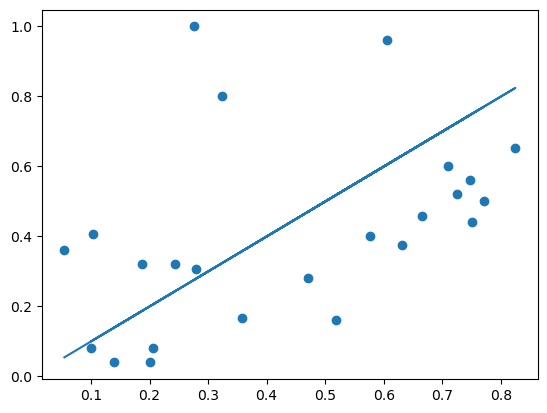

In [449]:
plt.scatter(task_mapping_weighted, df_tasks.iloc[check_ref_index].filter(like="Q"))
plt.plot(task_mapping_weighted, task_mapping_weighted)

In [457]:
pearsonr(task_mapping_weighted, df_tasks.iloc[check_ref_index].filter(like="Q")), pearsonr(df_tasks.filter(like="Q").mean(), df_tasks.iloc[check_ref_index].filter(like="Q"))

(PearsonRResult(statistic=0.4355362459295947, pvalue=0.03339555837523412),
 PearsonRResult(statistic=0.41752735741700187, pvalue=0.04235010018811647))

In [452]:
df_ranking["gpt_rank"] = df_ranking["relevance"].rank(ascending=False)
df_ranking["cosine_sim"] = cosine_similarity(df_tasks.iloc[df_ranking["task_index"]].filter(regex="Q"), np.array(df_tasks.iloc[check_ref_index].filter(regex="Q")).reshape(1, -1))
df_ranking["cosine_rank"] = df_ranking["cosine_sim"].rank(ascending=False)

In [453]:
spearmanr(df_ranking["relevance"], df_ranking["cosine_sim"])

SignificanceResult(statistic=0.2084799068142108, pvalue=0.03642373426983344)

In [641]:
df_ranking

,index,relevance,task_index
0,task_27,-0.559995,27
1,task_11,-0.536048,11
2,task_22,-0.444604,22
3,task_9,-0.405334,9
4,task_13,-0.402442,13
...,...,...,...
97,task_3,0.444098,3
98,task_71,0.446568,71
99,task_79,0.504755,79
100,task_63,0.587741,63


In [455]:
cosine_similarity(np.array(df_tasks.iloc[0].filter(regex="Q")).reshape(1, -1), df_tasks.iloc[df_ranking["task_index"]].filter(regex="Q"))

array([[0.46452196, 0.95111033, 0.9678428 , 0.68791324, 0.95875015,
        0.43385029, 0.9568637 , 0.85121745, 0.9402143 , 0.70559155,
        0.4630326 , 0.86078087, 0.95785052, 0.9568264 , 0.94642702,
        0.5282385 , 0.95369602, 0.8974454 , 0.75364315, 0.66806335,
        0.86572712, 0.74829075, 0.94628539, 0.90268905, 0.89256862,
        0.40198556, 0.95782252, 0.79699318, 0.6264073 , 0.96427111,
        0.81101416, 0.75196985, 0.8208787 , 0.63221209, 0.83155593,
        0.91182871, 0.94111685, 0.66521806, 0.94383709, 0.8834651 ,
        0.7135291 , 0.91886638, 0.50573608, 0.95110112, 0.93764903,
        0.90925862, 0.65404776, 0.97529497, 0.96222289, 0.81954991,
        0.80572639, 0.92069528, 0.84072098, 0.91122131, 0.71211563,
        0.93821443, 0.97514961, 0.85585793, 0.98495078, 0.75223478,
        0.72565537, 0.98440826, 0.96005978, 0.98152603, 0.7746154 ,
        0.91785253, 0.98089453, 0.77236249, 0.91546112, 0.88867913,
        1.        , 0.68862722, 0.91359172, 0.86

In [456]:
df_ranking

,index,relevance,task_index,gpt_rank,cosine_sim,cosine_rank
0,task_83,-0.539972,83,101.0,0.758800,55.0
1,task_22,-0.517685,22,100.0,0.785680,45.0
2,task_27,-0.510678,27,99.0,0.740895,67.0
3,task_100,-0.489585,100,98.0,0.822883,24.0
4,task_47,-0.411937,47,97.0,0.702459,82.0
...,...,...,...,...,...,...
97,task_77,0.507607,77,5.0,0.884068,9.0
98,task_28,0.545725,28,4.0,0.702267,83.0
99,task_60,0.586822,60,3.0,0.856944,16.0
100,task_55,0.590022,55,2.0,0.814149,26.0


# Aggregate analysis 

In [629]:
param_corr = []
ranking_corr = []
weighted_vectors = []

for check_ref_index in sample_task_ids:
    pairwise_comparisons = pickle.load(open(f"pairwise_comparisons/comparisons_{check_ref_index}.pkl", "rb"))
    parsed_comparisons = []

    for comparison in pairwise_comparisons:
        try:
            response_dict = ast.literal_eval(comparison["gpt_response"].choices[0].message.content)
            winner = response_dict["choice"]
            assert(winner in {"A", "B"})

            if winner == "A":
                loser = "B"
            else:
                loser = "A"



            temp_dict = {}
            temp_dict["task_"+str(comparison["A"])] = 1
            temp_dict["task_"+str(comparison["B"])] = -1
            temp_dict["a_won"] = int(winner=="A")
            temp_dict["rationale"] = comparison

            parsed_comparisons.append(temp_dict)

        except: 
            print("Error with task")
            
    df_elo = pd.DataFrame(parsed_comparisons).fillna(0)
    ranking_model = smf.ols("a_won ~ " + "+".join(df_elo.filter(like="task_")), data=df_elo).fit()
    
    df_ranking = ranking_model.params.sort_values().reset_index().query("index != 'Intercept'")
    df_ranking.columns = ["index", "relevance"]
    df_ranking["task_index"] = [int(x.split("_")[1]) for x in df_ranking["index"]]
    task_mapping_weighted = np.matmul(df_ranking["relevance"].clip(lower=0),df_tasks.iloc[df_ranking["task_index"]].filter(regex="Q").to_numpy()) / sum(df_ranking["relevance"].clip(lower=0))
    weighted_vectors.append(task_mapping_weighted)
    
    param_corr.append((pearsonr(task_mapping_weighted, df_tasks.iloc[check_ref_index].filter(like="Q")), pearsonr(df_tasks.filter(like="Q").mean(), df_tasks.iloc[check_ref_index].filter(like="Q"))))
    df_ranking["gpt_rank"] = df_ranking["relevance"].rank(ascending=False)
    df_ranking["cosine_sim"] = cosine_similarity(df_tasks.iloc[df_ranking["task_index"]].filter(regex="Q"), np.array(df_tasks.iloc[check_ref_index].filter(regex="Q")).reshape(1, -1))
    df_ranking["cosine_rank"] = df_ranking["cosine_sim"].rank(ascending=False)
    
    ranking_corr.append(spearmanr(df_ranking["relevance"], df_ranking["cosine_sim"]))

Error with task
Error with task
Error with task
Error with task
Error with task
Error with task
Error with task
Error with task
Error with task


In [628]:
df_ranking

,index,relevance,task_index,gpt_rank,cosine_sim,cosine_rank
0,task_27,-0.559995,27,101.0,0.837073,50.0
1,task_11,-0.536048,11,100.0,0.806346,73.0
2,task_22,-0.444604,22,99.0,0.816063,64.0
3,task_9,-0.405334,9,98.0,0.836819,52.0
4,task_13,-0.402442,13,97.0,0.752025,90.0
...,...,...,...,...,...,...
97,task_3,0.444098,3,5.0,0.649348,96.0
98,task_71,0.446568,71,4.0,0.901959,14.0
99,task_79,0.504755,79,3.0,0.911341,10.0
100,task_63,0.587741,63,2.0,0.910267,11.0


In [603]:
ranking_corr

[SignificanceResult(statistic=0.43616773442050083, pvalue=5.131380734164129e-06),
 SignificanceResult(statistic=0.2770762958648806, pvalue=0.005030679831401483),
 SignificanceResult(statistic=0.561642399534071, pvalue=9.942186269144228e-10),
 SignificanceResult(statistic=0.08882935352358766, pvalue=0.3770418405086696),
 SignificanceResult(statistic=0.2084799068142108, pvalue=0.03642373426983344)]

In [475]:
df_tasks.loc[sample_task_ids[-2]].task_desc

'Participants were given the description of a product from Kickstarter. For example, they could read about "Soapstone: the Sustainable Travel Soap Dispenser," and learn about its features.2. Objective / GoalThe goal was to write an online text advertisement of no more than 30 characters for the Kickstarter product. The advertisement had to be creative, informative, and get people to click. When working in teams, participants needed to submit a single collective writeup, produced within the time limit.'

In [613]:
df_param_corrs = pd.DataFrame({"dim_label":df_tasks.filter(like="Q").columns,
              "corr":[pearsonr(df_tasks.loc[sample_task_ids][x], np.array(weighted_vectors)[:,index]).statistic for index, x in enumerate(df_tasks.filter(like="Q").columns)],
              "p":[pearsonr(df_tasks.loc[sample_task_ids][x], np.array(weighted_vectors)[:,index]).pvalue for index, x in enumerate(df_tasks.filter(like="Q"))]})

df_param_corrs["dim_index"] = [int(re.search(r'Q(\d+)', x)[1]) for x in df_param_corrs["dim_label"]]
dict_label_to_name = dict(zip(list(df_param_corrs.sort_values("dim_index")["dim_label"].values[:6]) + ["Q25_type6_mixed_motive"]  + list(df_param_corrs.sort_values("dim_index")["dim_label"].values[6:-1]), 
                              pd.read_csv("24_dimensions_clean.csv")["Dimension Name"]))
df_param_corrs["dim_name"] = df_param_corrs["dim_label"].map(dict_label_to_name)

df_param_corrs = df_param_corrs.merge(pd.read_csv("24_dimensions_clean.csv"), left_on="dim_name", right_on="Dimension Name", how="left")

In [618]:
df_param_corrs.sort_values("corr", ascending=False)[["Dimension Name", "corr", "p"]].to_clipboard()

In [620]:
df_param_corrs.sort_values("corr", ascending=False)[["Dimension Name", "corr", "p"]].round(2).to_clipboard()

In [623]:
df_param_corrs.sort_values("corr", ascending=False)[["Dimension Name", "Question Text", "corr", "p"]].round(2).to_clipboard()

In [621]:
df_param_corrs

,dim_label,corr,p,dim_index,dim_name,Dimension Name,Question Text,Source
0,Q1concept_behav,0.987856,0.001604,1,Conceptual-Behavioral,Conceptual-Behavioral,Does this task primarily require physical effo...,McGrath
1,Q3type_1_planning,0.342206,0.572950,3,Type 1 (Planning),Type 1 (Planning),"Is this a ""planning"" task? In other words, is ...",McGrath
2,Q4type_2_generate,0.899598,0.037609,4,Type 2 (Generate),Type 2 (Generate),"Is this a ""generation"" or ""brainstorming"" task...",McGrath
3,Q6type_5_cc,0.909172,0.032408,6,Type 5 (Cognitive Conflict),Type 5 (Cognitive Conflict),Is one of the main purpose(s) of this task to ...,McGrath
4,Q7type_7_battle,0.501463,0.389390,7,Type 7 (Battle),Type 7 (Battle),Can the outcome of this task be described in w...,McGrath
5,Q8type_8_performance,0.900456,0.037134,8,Type 8 (Performance),Type 8 (Performance),Does the task have an all-or-nothing outcome? ...,McGrath
6,Q9divisible_unitary,0.791496,0.110645,9,Divisible-Unitary,Divisible-Unitary,Is it efficient and useful for members of the ...,Steiner
7,Q10maximizing,0.611568,0.273038,10,Maximizing,Maximizing,Is the goal (or one of the goals) of this task...,Steiner
8,Q11optimizing,0.589623,0.295377,11,Optimizing,Optimizing,Is the goal (or one of the goals) of this task...,Steiner
9,Q13outcome_multip,0.075585,0.903854,13,Outcome Multiplicity,Outcome Multiplicity,"Is there only one ""best"" solution (or possible...","Shaw, Zigurs et al."


In [546]:
pd.read_csv("24_dimensions_clean.csv")["Dimension Name"]

0                         Conceptual-Behavioral
1                     Intellectual-Manipulative
2                             Type 1 (Planning)
3                             Type 2 (Generate)
4                              Creativity Input
5                   Type 5 (Cognitive Conflict)
6                         Type 6 (Mixed-Motive)
7                               Type 7 (Battle)
8                          Type 8 (Performance)
9                             Divisible-Unitary
10                                   Maximizing
11                                   Optimizing
12                         Outcome Multiplicity
13                 Solution Scheme Multiplicity
14                       Decision Verifiability
15                             Shared Knowledge
16                       Within-System Solution
17                       Answer Recognizability
18                             Time Solvability
19    Type 3 and Type 4 (Objective Correctness)
20                      Intellective-Jud

In [547]:
dict_label_to_name

{'Q1concept_behav': 'Conceptual-Behavioral',
 'Q2intel_manip_1': 'Intellectual-Manipulative',
 'Q3type_1_planning': 'Type 1 (Planning)',
 'Q4type_2_generate': 'Type 2 (Generate)',
 'Q5creativity_input_1': 'Creativity Input',
 'Q6type_5_cc': 'Type 5 (Cognitive Conflict)',
 'Q25_type6_mixed_motive': 'Type 6 (Mixed-Motive)',
 'Q7type_7_battle': 'Type 7 (Battle)',
 'Q8type_8_performance': 'Type 8 (Performance)',
 'Q9divisible_unitary': 'Divisible-Unitary',
 'Q10maximizing': 'Maximizing',
 'Q11optimizing': 'Optimizing',
 'Q13outcome_multip': 'Outcome Multiplicity',
 'Q14sol_scheme_mul': 'Solution Scheme Multiplicity',
 'Q15dec_verifiability': 'Decision Verifiability',
 'Q16shared_knowledge': 'Shared Knowledge',
 'Q17within_sys_sol': 'Within-System Solution',
 'Q18ans_recog': 'Answer Recognizability',
 'Q19time_solvability': 'Time Solvability',
 'Q20type_3_type_4': 'Type 3 and Type 4 (Objective Correctness)',
 'Q21intellective_judg_1': 'Intellective-Judgmental',
 'Q22confl_tradeoffs': 'Confl

In [535]:
pd.read_csv("24_dimensions_clean.csv")

,Dimension Name,Question Text,Source
0,Conceptual-Behavioral,Does this task primarily require physical effo...,McGrath
1,Intellectual-Manipulative,What is the fraction of physical (as opposed t...,Shaw
2,Type 1 (Planning),"Is this a ""planning"" task? In other words, is ...",McGrath
3,Type 2 (Generate),"Is this a ""generation"" or ""brainstorming"" task...",McGrath
4,Creativity Input,What fraction of the effort required for this ...,New; Continuous version of Type 2 (Generate)
5,Type 5 (Cognitive Conflict),Is one of the main purpose(s) of this task to ...,McGrath
6,Type 6 (Mixed-Motive),"During this task, group members pursue differe...",McGrath
7,Type 7 (Battle),Can the outcome of this task be described in w...,McGrath
8,Type 8 (Performance),Does the task have an all-or-nothing outcome? ...,McGrath
9,Divisible-Unitary,Is it efficient and useful for members of the ...,Steiner


# Do we see the dimensions in the rationales? 

In [503]:
def parse_gpt_rationale(response):
    try:
        return ast.literal_eval(response.choices[0].message.content)["rationale"]
    except:
        return None

In [506]:
list_rationales = list(itertools.chain(*[pickle.load(open(f"pairwise_comparisons/comparisons_{x}.pkl", "rb")) for x in sample_task_ids]))
list_rationales = [parse_gpt_rationale(x["gpt_response"]) for x in list_rationales]

In [516]:
rationale_tokens = [y.lower() for y in list(itertools.chain(*[x.split() for x in list_rationales if x is not None]))]

In [520]:
pd.Series(rationale_tokens).value_counts()[:50]

the                15526
and                11961
a                  11545
to                 11421
task               10623
of                  7483
in                  7292
reference           5628
on                  5530
is                  5316
team                4310
participants        4184
both                3815
tasks               3442
more                3347
similar             3045
which               2702
must                2400
involves            2359
dynamics            2171
involve             2170
terms               2070
other               2066
require             2053
or                  1911
hand,               1906
b,                  1843
because             1802
b                   1799
with                1721
individual          1670
together            1639
about               1566
based               1454
decision-making     1432
a,                  1428
within              1423
where               1351
work                1344
strategic           1266


# Use embeddings as a benchmark 

In [566]:
embeddings = client.embeddings.create(
        model="text-embedding-ada-002",
        input=df_tasks["task_desc"].to_list(),
        encoding_format="float"
    )

In [582]:
df_tasks.loc[:,[f"embed{x}" for x in range(1536)]] = pd.DataFrame([x.embedding for x in embeddings.data]).add_prefix("embed")

In [589]:
embed_ranking_corr = []

for task_index in df_tasks.index:
    mapping_similarity = cosine_similarity(df_tasks.drop(index=task_index).filter(regex="Q"), 
                                           np.array(df_tasks.iloc[task_index].filter(regex="Q")).reshape(1, -1))
    
    embed_similarity = cosine_similarity(df_tasks.drop(index=task_index).filter(regex="embed"), 
                                         np.array(df_tasks.iloc[task_index].filter(regex="embed")).reshape(1, -1))
    
    embed_ranking_corr.append(spearmanr(mapping_similarity, embed_similarity))

(array([ 4.,  1.,  5., 11.,  7., 10., 15., 20., 23.,  6.]),
 array([-0.03341875,  0.04150961,  0.11643797,  0.19136634,  0.2662947 ,
         0.34122306,  0.41615143,  0.49107979,  0.56600815,  0.64093652,
         0.71586488]),
 <BarContainer object of 10 artists>)

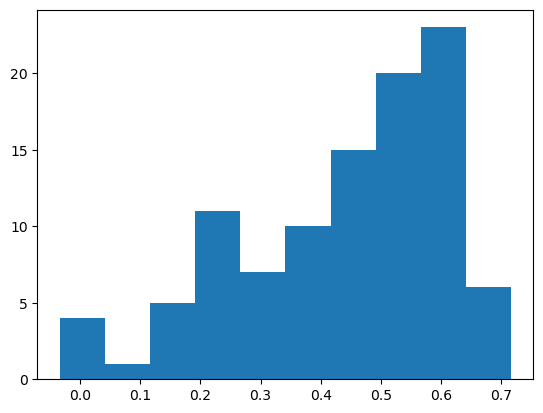

In [592]:
plt.hist([x.statistic for x in embed_ranking_corr])

In [604]:
ranking_corr

[SignificanceResult(statistic=0.43616773442050083, pvalue=5.131380734164129e-06),
 SignificanceResult(statistic=0.2770762958648806, pvalue=0.005030679831401483),
 SignificanceResult(statistic=0.561642399534071, pvalue=9.942186269144228e-10),
 SignificanceResult(statistic=0.08882935352358766, pvalue=0.3770418405086696),
 SignificanceResult(statistic=0.2084799068142108, pvalue=0.03642373426983344)]

In [607]:
sample_embed_rankings = [embed_ranking_corr[x] for x in sample_task_ids]

In [608]:
for index in range(len(ranking_corr)):
    print(f"{ranking_corr[index].statistic}", f"{sample_embed_rankings[index].statistic}")

0.43616773442050083 0.2116948165404776
0.2770762958648806 0.30957483983692485
0.561642399534071 0.27737914967967386
0.08882935352358766 0.03815958066394874
0.2084799068142108 0.32666278392545134


In [609]:
for index in range(len(ranking_corr)):
    print(f"{ranking_corr[index].pvalue}", f"{sample_embed_rankings[index].pvalue}")

5.131380734164129e-06 0.033572126928206616
0.005030679831401483 0.0016314196563971069
9.942186269144228e-10 0.004981079836021468
0.3770418405086696 0.7047891852359678
0.03642373426983344 0.0008560228620514152


In [612]:
for x in df_tasks["task"][sample_task_ids]: 
    print(x)

Investment game (hidden-profile)
Putting food into categories
Checkers
Advertisement writing
Apache helicopter flight simulator (Longbow2)


In [624]:
for x in df_tasks["task_desc"][sample_task_ids]:
    print(x, "\n")

Participants are asked to take the role of the board of directors of an investment company. Their task is to evaluate three companies available for acquisition using a specified set of investment criteria and to provide a rank ordering of the companies' desirability. Profiles on each of the three companies include the financial opinions of in-house and external financial analysts, information on the company's business strategy, strength of its management team, market position, and human resources practices. The investment criteria for evaluating the companies include long-term financial return, the degree of risk tolerated, the ability of the company to stand on its own and fit with the company's general business philosophy.Each participant is given different information about the investment options, which means that initial majority and minority opinions are likely to be divided. Participants are then asked to discuss the investment strategy. After they discuss, the group must come to

# OLD

In [141]:
pairwise_comparisons[set(["A","B"])] = 1

TypeError: unhashable type: 'set'

In [642]:
test_pairwise = pairwise_task_comparison(df_tasks["task_desc"][97], df_tasks["task_desc"][27], df_tasks["task_desc"][93])

In [643]:
print(df_tasks["task_desc"][97]+"\n\n", df_tasks["task_desc"][27]+"\n\n", df_tasks["task_desc"][93])

Participants are asked to take the role of the board of directors of an investment company. Their task is to evaluate three companies available for acquisition using a specified set of investment criteria and to provide a rank ordering of the companies' desirability. Profiles on each of the three companies include the financial opinions of in-house and external financial analysts, information on the company's business strategy, strength of its management team, market position, and human resources practices. The investment criteria for evaluating the companies include long-term financial return, the degree of risk tolerated, the ability of the company to stand on its own and fit with the company's general business philosophy.Each participant is given different information about the investment options, which means that initial majority and minority opinions are likely to be divided. Participants are then asked to discuss the investment strategy. After they discuss, the group must come to

In [645]:
df_tasks["task"].iloc[[97,27,93]]

97       Investment game (hidden-profile)
27                          Recall images
93    Best job candidate (hidden-profile)
Name: task, dtype: object

In [644]:
test_pairwise.choices[0].message.content

'{"choice":"B", "rationale":"Task B is most similar to the reference task in terms of team dynamics because both tasks involve group members receiving different pieces of information that need to be shared and discussed in order to make an informed decision. In the reference task, participants act as a board of directors evaluating companies for acquisition with different information about the investment options, leading to initial divided opinions. In Task B, participants evaluate job candidates with each member having access to only partial information about each candidate, which could lead to an initial preference based on incomplete data. Both tasks require collaborative analysis, discussion, and consensus-building to arrive at the \'correct\' decision based on the full set of information. Task A, on the other hand, is focused on individual memory recall and does not involve group discussion or decision-making, making it less similar to the reference task in terms of team dynamics.